In [ ]:
# NOT WORKING

In [2]:
from langchain_ollama import ChatOllama
from ddgs import DDGS
import ast
import operator
import time
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List, Annotated
from langchain_core.tools import tool, Tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.prompts import PromptTemplate
import json
from json import loads
from pydantic import BaseModel, ValidationError
from typing import Literal, Union, Optional
import re
import json 
import uuid

In [3]:
#llm  = ChatOllama(model="deepseek-r1:8b")
#llm  = ChatOllama(model="llama3.2:3b")
#llm  = ChatOllama(model="llama3.1:8b")
llm = ChatOllama(model="llama3.1:8b", temperature=0.3)

In [4]:
class AgentResponse(BaseModel):
    node: Optional[str] = None 
    thought: Optional[str] = None 
    action: Union[Literal["Final Answer"], str]
    input: Optional[str] = None 
    output: Optional[str] = None 

    @classmethod
    def from_dict(cls, data: Union[dict, str]) -> 'AgentResponse':
        """Handle both dictionary objects and string representations"""
        if isinstance(data, str):
            try:
                # First try JSON parsing
                data = json.loads(data)
            except json.JSONDecodeError:
                try:
                    # Then try Python literal evaluation
                    data = ast.literal_eval(data)
                except (SyntaxError, ValueError) as e:
                    raise ValueError(f"Invalid string format: {e}")
        
        try:
            return cls(**data)
        except ValidationError as e:
            errors = e.errors()
            msg = ", ".join([f"{err['loc'][0]}: {err['msg']}" for err in errors])
            raise ValueError(f"Validation error: {msg}")
        

    @classmethod
    def from_json(cls, json_str: str) -> 'AgentResponse':
        try:
            data = json.loads(json_str)
            return cls(**data)
        except json.JSONDecodeError as e:
            raise ValueError(f"Invalid JSON: {e}")
        except ValidationError as e:
            raise ValueError(f"Validation error: {e}")

    def to_json(self) -> str:
        """Convert this instance to JSON string."""
        return self.model_dump_json(exclude_none=True)

# Define state for the graph
class AgentState(TypedDict):
    problem: str
    messages: Annotated[List, "The messages in the conversation"]
    iterations: int 



In [5]:
@tool
def calculator(expression: str) -> str:
    """Calculator for mathematical expressions. Input: mathematical expression like '2+2' or 'abs(-5)'"""
    try:
        # Safe expression evaluator using AST
        def safe_eval(node):
            if isinstance(node, ast.Constant):
                return node.value
            elif isinstance(node, ast.BinOp):
                left = safe_eval(node.left)
                right = safe_eval(node.right)
                return {
                    ast.Add: operator.add,
                    ast.Sub: operator.sub,
                    ast.Mult: operator.mul,
                    ast.Div: operator.truediv,
                    ast.Pow: operator.pow,
                    ast.Mod: operator.mod,
                }[type(node.op)](left, right)
            elif isinstance(node, ast.UnaryOp):
                operand = safe_eval(node.operand)
                return {
                    ast.UAdd: operator.pos,
                    ast.USub: operator.neg,
                }[type(node.op)](operand)
            elif isinstance(node, ast.Call):
                func_name = node.func.id
                args = [safe_eval(arg) for arg in node.args]
                
                # Safe math functions
                safe_functions = {
                    'abs': abs,
                    'round': round,
                    'sqrt': math.sqrt,
                    'sin': math.sin,
                    'cos': math.cos,
                    'tan': math.tan,
                    'log': math.log,
                    'log10': math.log10,
                    'exp': math.exp,
                    'floor': math.floor,
                    'ceil': math.ceil,
                }
                
                if func_name in safe_functions:
                    return safe_functions[func_name](*args)
                else:
                    raise ValueError(f"Function {func_name} not allowed")
            elif isinstance(node, ast.Name):
                # Allow mathematical constants
                constants = {
                    'pi': math.pi,
                    'e': math.e,
                }
                if node.id in constants:
                    return constants[node.id]
                else:
                    raise ValueError(f"Variable {node.id} not allowed")
            else:
                raise ValueError(f"Operation {type(node)} not supported")
        
        # Parse and evaluate
        parsed = ast.parse(expression, mode='eval')
        result = safe_eval(parsed.body)
        return str(result)
        
    except Exception as e:
        return f"Math error: {str(e)}"

In [6]:
@tool
def ddg_search(query: str) -> str:
    """Search DuckDuckGo for current information. Input: search query string"""
    try:
        # Retry logic to handle transient issues, know issue
        results = None
        RETRY_COUNT = 5
        for i in range(RETRY_COUNT):
            with DDGS() as ddgs:
                results = ddgs.text(query, max_results=3)
            
            if results is not None and len(results) > 0:
                break
            time.sleep(1)

        if not results:
            return "No search results found"
            
        formatted_results = []
        for i, result in enumerate(results, 1):
            formatted_results.append(
                f"{i}. {result.get('title', 'No title')}\n"
                f"   {result.get('body', 'No description')}\n"
                f"   URL: {result.get('href', 'No URL')}"
            )
        
        return "\n\n".join(formatted_results)
    except Exception as e:
        return f"Search error: {str(e)}"


In [7]:
@tool
def get_weather(location: str) -> str:
    """Get weather information for a location."""
    # This is a mock function - in reality you'd call a weather API
    return f"The weather in {location} is sunny with a temperature of 72°F"

In [8]:
@tool
def word_count(text: str) -> str:
    """Count the number of words in a text."""
    words = len(text.split())
    return f"Word count: {words}"

In [9]:
tools = [
    Tool(
        name="get_weather",
        func=get_weather,
        description="Get weather information for a location. Input: location name like 'New York' or 'London'"
    ),
    Tool(
        name="word_count",
        func=word_count,
        description="Count the number of words in a text. Input: word like 'I am good' or 'Hello World' (it will return 'Word count: 3' or 'Word count: 2' respectively'"
   ),
    Tool(
        name="calculator",
        func=calculator,
        description="Calculator for mathematical expressions. Input: mathematical expression like '2+2' or 'abs(-5)'"
    ),
    Tool(
        name="ddg_search",
        func=ddg_search,
        description="Search DuckDuckGo (WEB Serach) for current information. Input: search query string"
    )
]
tool_node = ToolNode(tools)

In [10]:
# # Create system prompt

# system_prompt =  f"""You are an autonomous ReAct agent that solves problems by breaking them down by steps. You must use tools to perform action.

# **Tools Available:** {"\n".join([f"{tool.name}: {tool.description}" for tool in tools])}

# **Scratchpad** you have a scratchpad to store result from previous steps.
# Current Scratchpad: {scratchpad} 

# **Instructions:**
# 1. **Think** Analyze that user's request and your scratchpad. Decide the single next action to take.
# 2. **Act** Use one of the tool. Your action **MUST ALWAYS** output a single **JSON** in the following format:
# {{
#   "thought": "<your think or reasoning>`",
#   "action":  "<tool_name>" or "Final Answer"
#   "input":   "<tool argument string>, SKIP this when action is **'Final Answer'**",
#   "output":   "<Output string> when you are **calling a tool skip this key**, **only set for action is 'Final Answer'**. **tool_node will set the observation** and **agent_node will set the Final Answer if the action is 'Final Answer'**"
# }}
# 3. After an action, you will receive an **JSON** as mention before and **'output' key** will have the tool result. The tool response JOSN will be **automatically added to your Scratchpad**.
# 4. Repeat this process until you have solved the entire problem.
# 5. When you have the Final Answer after solving the entire problem. You MUST **set 'action' to "Final Answer"**
# and **set 'output' to the text you want to return to the user** in your **Act** JSON.

# **User Request**
# {message}

# Begin!

# """

# #print(f"System Prompt: {system_prompt}")

In [11]:
PROMPT_TEMPLATE = """
You are a ReAct agent that solves problems step-by-step using tools. Follow these rules STRICTLY:

**CORE RULES**
1. ALWAYS output exactly ONE JSON object per the structure below
2. Use tools for EVERY non-trivial operation
3. Check scratchpad BEFORE acting
4. Final Answer ONLY when entire problem is solved
5. If stuck after 15 steps, output Final Answer with best solution
6. Explicitly reference scratchpad values in thoughts

**TOOLS AVAILABLE**
{tool_list}

**SCRATCHPAD (Previous Results)** 
{scratchpad}

**INSTRUCTIONS**
1. **THINK**: 
   - Analyze request: "{problem}"
   - Review scratchpad for usable data
   - If scratchpad already have the output for the problem or sub-problem do not call the tool again for the same  
   - **STRICTLY ISTRUCTED** NOT TO CALL THE SAME TOOL WITH SAME INPUT, before calling a tool look into scratchpad
   - Plan exactly ONE next step, either using a tool or providing a "Final Answer"
   - Select EXACTLY ONE: tool or "Final Answer"
   - When selecting "action" is "Final Answer", populate 'output' with the final solution text
   - **STRICTLY ISTRUCTED** TO set `Output` field in 'Final Answer' JSON when action is "Final Answer"

2. **ACT** (Output STRICT JSON):
{{
  "thought": "<your think or reasoning> Brief reasoning (<2 sentences). REFERENCE scratchpad values like [1] or [3]",
  "action": "tool_name" or "Final Answer",
  "input": "<tool argument string>, SKIP this when action is **'Final Answer'**"  // OMIT ENTIRE KEY if Final Answer
}}

**Example of your output**
**FINAL ANSWER REQUIREMENTS**
- When solution is complete:
  {{
    "thought": "<Process summary>",
    "action": "Final Answer",
    "output": "<Complete solution with units. VERIFY critical steps.>"
  }}
- MUST omit 'input' key
- Include ALL results and units

**OUTPUT EXAMPLES**
**Tool use**:
```json
{{
  "thought": "First: calculate 5*8.",
  "action": "calculator",
  "input": "5 * 8"
}}

**Final Answer**
{{
  "thought": "Completed all steps. Verified calculations",
  "action": "Final Answer",
  "output": "Final result: 62.5\\n- Multiplication: 5*8 = 40\\n- Word count: 4\\n- Sum: 44\\n- SF temp: 18.5°C\\n- Total: 44 + 18.5 = 62.5"
}}

Begin now! Think step-by-step:
"""

PROMPT_TEMPLATE_JSON_PARSER = """
**TASK**: Extract the JSON object from the text below. Follow strictly:
1. Understand the text and compile complete JSON object as per the structure below
2. Output ONLY valid JSON - no other text
3. IGNORE all non-JSON content (markdown, comments, etc.)
4. If the "action" is "Final Answer" always Populate the 'output' field with the final solution 

**REQUIRED FORMAT EXAMPLES**:

Tool use MUST look like:
{{"thought": "...", "action": "...", "input": "..."}}

Final Answer MUST look like:
{{"thought": "...", "action": "Final Answer", "output": "..."}}


**TEXT TO PROCESS**:
{agent_output}

**YOUR OUTPUT (ONLY JSON)**:
"""

In [12]:
def extract_json(input_string):
    # Regex pattern to find JSON objects
    pattern = r'\{[\s\S]*?\"thought\"[\s\S]*?\}'
    
    match = re.search(pattern, input_string)
    if match:
        try:
            # Return parsed JSON
            return json.loads(match.group(0).strip())
        except json.JSONDecodeError:
            # Handle invalid JSON formatting
            return {"error": "Found JSON-like string but failed to parse"}
    return None

In [13]:
def agent_node(state: AgentState):

    print("\n" + "agent_node is called" +"\n")

    prompt = PROMPT_TEMPLATE.format(
        tool_list= ("\n".join([f"- {t.name}: {t.description}" for t in tools])),
        scratchpad= ("\n".join([f"Step-{idx + 1} (Type = {msg.type}) : \"\"\"{msg.content}\"\"\"" for idx, msg in enumerate(state["messages"])]) if state["messages"] else "None"),
        problem=state["problem"]
    )

    print("\n"*5)
    print("+" * 50)
    print("Prompt:", prompt)
    print("+" * 50)
    print("\n"*5)

    try: 
        response = llm.invoke(prompt)

        #print("\n"*5)
        #print("+" * 50)
        print(f"LLM Response: {response}")


        #llm_json = llm.invoke(PROMPT_TEMPLATE_JSON_PARSER.format(agent_output = response.content))
        llm_json = ""

        extract_json_result = extract_json(response.content if isinstance(response, AIMessage) else response)
        content = extract_json_result
        
        #content = llm_json.content

        print(f"Extract json result: {content} \nllm_json: {llm_json} \n ")

        try:
            agent_response = AgentResponse.from_dict(content)
        except Exception as e:
            print("Error parsing content:", e)
            agent_response = AgentResponse (
                node = "agent_node",
                thought = f"Agent crashed parser: {e}",
                action  = "Final Answer",
                input = content,
                output = None
            )

        agent_response.node = "agent_node"

        res = agent_response.to_json()
        
        tool_calls = [{
            "id": str(uuid.uuid4()),  # Generate unique ID
            "name": agent_response.action,
            "args": {"input": agent_response.input},
        }]

        #print("+" * 50, "\n"*5)
        return {
            "messages": state["messages"]
            + [AIMessage(content=res, tool_calls=tool_calls)],
            "iterations" : state["iterations"] + 1
        }
    except Exception as exc:
        res = AgentResponse (
                node = "agent_node",
                thought = f"Error in agent parsing: {exc}.",
                action  = "Final Answer",
                input  = None
            ).to_json
        return {
            "problem": state["problem"],
            "messages": state["messages"]
            + [AIMessage(content=res)],
            "iterations" : state["iterations"] + 1
        }


In [14]:

def tool_node(state: AgentState) -> AgentState:
    print("\n" + "tool_node is called" +"\n")

    #print("\n"*5)
    #print("*" * 50)
    messages = state["messages"]
    last_msg = messages[-1]
 
    if not isinstance(last_msg, AIMessage): 
        #print("ToolNode: last message is not AIMessage, returning state unchanged.")
        return state

    #print("\n" * 5, "1" * 5)

    jsosn_str_msg = last_msg.content
    try:
        agent_response = AgentResponse.from_json(jsosn_str_msg)
    except Exception as e:
        print(f"Error parsing content : {jsosn_str_msg}:", e) 
        return state

    #print("jsosn_str_msg:",jsosn_str_msg)
    #print("agent_response:", agent_response)
    #print("\n" * 5, "2" * 5)


    if agent_response.action in (None, "Final Answer"):
        print(f"ToolNode: action is {agent_response.action}', returning state unchanged.")
        return state

 
    tool_call =last_msg.tool_calls[-1]

    tool_fn = next((tool.func for tool in tools if tool.name == agent_response.action), None)

    print("tool_fn:", tool_fn)

    if tool_fn is None:
        res = f"⚠️ Unknown tool '{agent_response.action}' - cannot execute."
    else:
        try: 
            result = tool_fn.invoke(agent_response.input)
            observation = f"Observation: {result}"
            res = f"Tool executed successfully for problem '{agent_response.input}'. Final Answer is '{result}'"
        except Exception as e:
            observation = f"Error running {agent_response.action}({agent_response.input!r}): {e}"
            res = "Tool execution failed. Final Answer is " + observation

    print("Observation:", res)

    #print("*" * 50, "\n"*5) 
    return {
        "problem": state["problem"],
        "messages": messages + [ToolMessage(content=res, tool_call_id=tool_call["id"])],
        "iterations" : state["iterations"]
    }

In [15]:
# Define should_continue function
def should_continue(state: AgentState):
    #print("Checking if should continue...")
    
    if state["iterations"] >= 15:
        return "summerize_the_scratchpad_node"
    
    last_message = state["messages"][-1].content

    #print("\n"*2, "@"*5,"\n", "last_msg: ", last_message,"\n"*2, "@"*5)

    try:
        agent_response = AgentResponse.from_json(last_message)
    except Exception as e:
        print("Error parsing content:", e)
        agent_response = AgentResponse (
            thought = f"Agent crashed parser: {e}",
            action  = "Final Answer",
            input = None,
            output = last_message

        )
 
    if agent_response.action in ("Final Answer"):
        return "exit"
    
    return "tools"

In [16]:
def summerize_the_scratchpad_node(state: AgentState) -> AgentState:
    print("\n" + "summerize_the_scratchpad_node is called" +"\n")

    messages = state["messages"] 

    response = llm.invoke(
        f"Summarize the scratchpad messages:\n\n{messages}\n\n"
        "Return a concise summary of the key points in the scratchpad."
    ) 
    print("response", response)
    res = AgentResponse (
            thought = f"Summerizeing the scratchpad as max iteration is reached", 
            action  = "Final Answer",
            input = None,
            output = response.content,
            node= "summerize_the_scratchpad_node"
        ).to_json()
    return {
        "problem": state["problem"],
        "messages": messages + [ToolMessage(content=res, tool_call_id=str(uuid.uuid4()))],
        "iterations" : state["iterations"]
    }

In [17]:
workflow = StateGraph(AgentState)


workflow.add_node("agent", agent_node)
workflow.add_node("tools",  tool_node)
workflow.add_node("summerize_the_scratchpad_node", summerize_the_scratchpad_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",                  # The node to evaluate after execution
    should_continue,          # A function that decides what happens next
    path_map={"tools": "tools", "summerize_the_scratchpad_node" : "summerize_the_scratchpad_node" ,"exit": END}
)

workflow.add_edge("tools", "agent") 
workflow.add_edge("summerize_the_scratchpad_node", END)

app = workflow.compile()


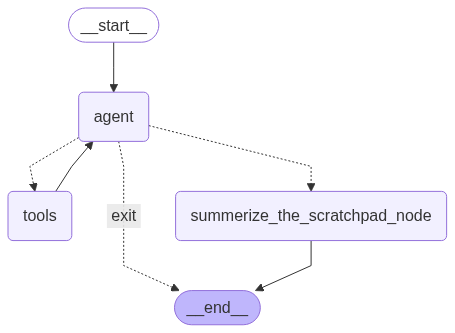

In [18]:
app

In [19]:
def run_langgraph_agent(question: str) :
    """Run the LangGraph ReACT agent"""
    try:
        initial_state = {
            "problem": question,
            "messages": [HumanMessage(content=question)],
            "iterations": 0
        }
        
        result = app.invoke(initial_state)
        
        print("\n"*5)
        print("!"*50)
        print("run_langgraph_agent:", result)
        print("!"*50, "\n" * 5)

        # Extract final answer
        final_message = result["messages"][-1].content
        
        try:
            agent_response = AgentResponse.from_json(final_message)

            print("Agent Response:", agent_response)

            return {"agent_response" : agent_response, "iterations": result["iterations"]}
        except Exception as e:
            print("Error parsing content:", e)
        
        return {
            "agent_response" : AgentResponse(output=final_message, action="Final Answer", thought="Error parsing final message", input=None),
            "iterations": result["iterations"]
        }
        
    except Exception as e:
        return f"Error: {str(e)}"

In [ ]:
questions = [
        "What is (5 + 7) ?",   
        "Search for latest AI developments in 2024", 
        "Calculate 5 * 8 and then count words in 'The quick brown fox'. After that sum both the results. find the weather in San Francisco and add the temperature with previous sum.",
        "Find recent news about LangChain framework",
        "Calculate -7.5 * 4",
        "Calculate 15 * 8 and then count words in 'The quick brown fox'",
        "Calculate 5 * 8 and then count words in 'The quick brown fox'. After that sum both the result'",
        "Calculate 5 * 8 and then count words in 'The quick brown fox'.  Then search the web with that final sum",
        "Search for latest AI developments in 2025",
        "Find recent news about LangChain framework",
        "Calculate -7.5 * 4",
        "What is 25 * 4 + 10?",
        "What's the weather like in San Francisco?",
        "How many words are in 'Hello world from LangGraph'?"
    ]
    
    
for i, question in enumerate(questions, 1):
    print(f"\n{i}. {question}")
    print("-" * 50)
    
    response = run_langgraph_agent(question)

    print("response:", response )

    agent_response = response["agent_response"]
    print(agent_response)
    print(f"Answer: {agent_response.output}")
    print(f"Number of iteration: {response['iterations']}")
    print("-" * 50)


1. What is (5 + 7) ?
--------------------------------------------------

agent_node is called







++++++++++++++++++++++++++++++++++++++++++++++++++
Prompt: 
You are a ReAct agent that solves problems step-by-step using tools. Follow these rules STRICTLY:

**CORE RULES**
1. ALWAYS output exactly ONE JSON object per the structure below
2. Use tools for EVERY non-trivial operation
3. Check scratchpad BEFORE acting
4. Final Answer ONLY when entire problem is solved
5. If stuck after 15 steps, output Final Answer with best solution
6. Explicitly reference scratchpad values in thoughts

**TOOLS AVAILABLE**
- get_weather: Get weather information for a location. Input: location name like 'New York' or 'London'
- word_count: Count the number of words in a text. Input: word like 'I am good' or 'Hello World' (it will return 'Word count: 3' or 'Word count: 2' respectively'
- calculator: Calculator for mathematical expressions. Input: mathematical expression like '2+2' or 'abs(-5)'
- ddg_searc